In [ ]:
# !pip install finnhub-python

In [2]:
import os
from datetime import datetime, timedelta

import finnhub
import numpy as np
import pandas as pd
import yfinance as yf

# from google.colab import userdata

In [3]:
np.random.seed(42)
ticker = "NVDA"
end = datetime.today() - timedelta(days=1)
start = end - timedelta(days=30)
start_str, end_str = start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d")

In [4]:
stock_df = yf.download(
    ticker, start=start_str, end=end, auto_adjust=True, progress=False
)[["Close"]].reset_index()
stock_df.columns = ["date", "price"]
stock_df

,date,price
0,2025-06-23,144.169998
1,2025-06-24,147.899994
2,2025-06-25,154.309998
3,2025-06-26,155.020004
4,2025-06-27,157.750000
5,2025-06-30,157.990005
6,2025-07-01,153.300003
7,2025-07-02,157.250000
8,2025-07-03,159.339996
9,2025-07-07,158.240005


In [6]:
finnhub_client = finnhub.Client(api_key=os.getenv("FINNHUB_API_KEY"))

In [7]:
def fetch_news_in_chunks(ticker, start_date, end_date, client, chunk_days=7):
    all_news = []
    current = start_date
    while current <= end_date:
        chunk_end = min(current + timedelta(days=chunk_days - 1), end_date)
        news_chunk = client.company_news(
            ticker,
            _from=current.strftime("%Y-%m-%d"),
            to=chunk_end.strftime("%Y-%m-%d"),
        )
        all_news.extend(news_chunk)
        current = chunk_end + timedelta(days=1)
    return pd.DataFrame(all_news)

In [ ]:
start_dt = datetime.strptime(start_str, "%Y-%m-%d").date()
end_dt = (stock_df["date"].max() - timedelta(days=1)).date()
news = fetch_news_in_chunks(ticker, start_dt, end_dt, finnhub_client, 3)

In [37]:
news_df = news[["datetime", "headline", "summary"]].copy()
news_df["datetime"] = pd.to_datetime(news_df["datetime"], unit="s")
news_df["assigned_date"] = news_df["datetime"].apply(
    lambda x: (x + timedelta(days=1)).date() if x.hour >= 16 else x.date()
)

In [38]:
news_df.head()

,datetime,headline,summary,assigned_date
0,2025-06-24 00:00:00,Better Artificial Intelligence Stock: BigBear....,Nations are ramping up artificial intelligence...,2025-06-24
1,2025-06-23 20:31:41,3 Things to Watch Ahead of the Nvidia Annual M...,Nvidia shares are in focus ahead of the AI dar...,2025-06-24
2,2025-06-23 20:00:06,"AI Giants Nvidia, Meta And More Fuel This Powe...",As AI leaders like Nvidia and Meta drive deman...,2025-06-24
3,2025-06-23 19:53:00,"NVIDIA Forges Strategic AI Partnerships, Repor...",NVIDIA Corporation (NASDAQ:NVDA) is one of the...,2025-06-24
4,2025-06-23 19:45:00,US stocks aren’t safe in heated global tension...,Bitcoin's volatility drops below major U.S. st...,2025-06-24


<Axes: xlabel='assigned_date'>

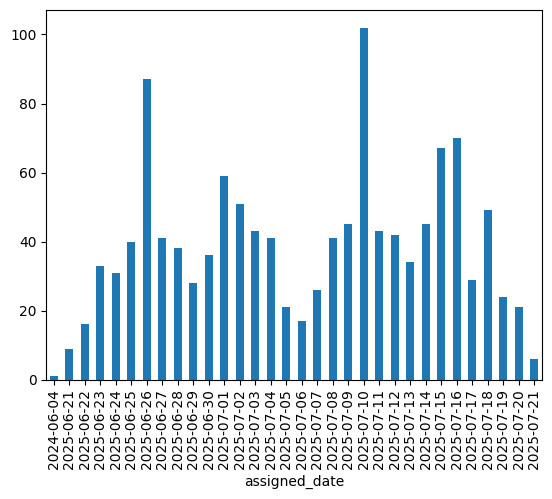

In [39]:
news_df["assigned_date"].value_counts().sort_index().plot(kind="bar")

<Axes: xlabel='assigned_date'>

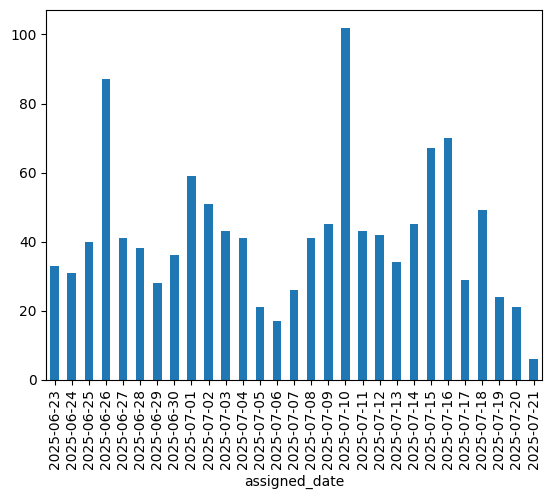

In [40]:
news_df = news_df[
    (news_df["assigned_date"] >= stock_df["date"].min().date())
    & (news_df["assigned_date"] <= stock_df["date"].max().date())
].copy()
news_df["assigned_date"].value_counts().sort_index().plot(kind="bar")

In [ ]:
# news_df.to_csv("../data/processed/6-23_to_7-21_nvda_news.csv", index=False)
# stock_df.to_csv("../data/processed/6-23_to_7-21_nvda_stock.csv", index=False)